In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
dataset = 'https://www.kaggle.com/datasets/stealthtechnologies/traffic-time-series-dataset'
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: h
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/stealthtechnologies/traffic-time-series-dataset


100%|██████████| 47.3k/47.3k [00:00<00:00, 42.5MB/s]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

In [ ]:
df = pd.read_csv('/content/traffic-time-series-dataset/traffic_dataset_with_trend.csv',parse_dates=True)

In [ ]:
df.shape

(8736, 4)

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [ ]:
df.set_index('Timestamp',inplace=True)

In [ ]:
df.head()

,Weather,Events,Traffic Volume
Timestamp,,,
2023-01-01 00:00:00,Cloudy,False,803.0
2023-01-01 01:00:00,Clear,False,861.0
2023-01-01 02:00:00,Clear,False,582.0
2023-01-01 03:00:00,Cloudy,False,236.0
2023-01-01 04:00:00,Cloudy,False,569.0


In [ ]:
# df.drop(columns=['Weather','Events'],axis=1,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8736 entries, 2023-01-01 00:00:00 to 2023-12-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Weather         8736 non-null   object 
 1   Events          8736 non-null   bool   
 2   Traffic Volume  8736 non-null   float64
dtypes: bool(1), float64(1), object(1)
memory usage: 213.3+ KB


In [ ]:
df.head()

,Weather,Events,Traffic Volume
Timestamp,,,
2023-01-01 00:00:00,Cloudy,False,803.0
2023-01-01 01:00:00,Clear,False,861.0
2023-01-01 02:00:00,Clear,False,582.0
2023-01-01 03:00:00,Cloudy,False,236.0
2023-01-01 04:00:00,Cloudy,False,569.0


In [ ]:
decompose = seasonal_decompose(df['Traffic Volume'],model='additive',period=24)


In [ ]:
w_event=['Clear','Cloudy','Rain','Snow']
encoder = OrdinalEncoder()
df[['Weather']] = encoder.fit_transform(df[['Weather']])

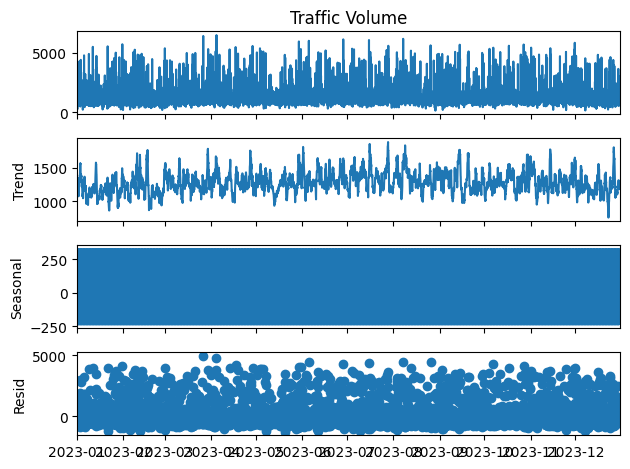

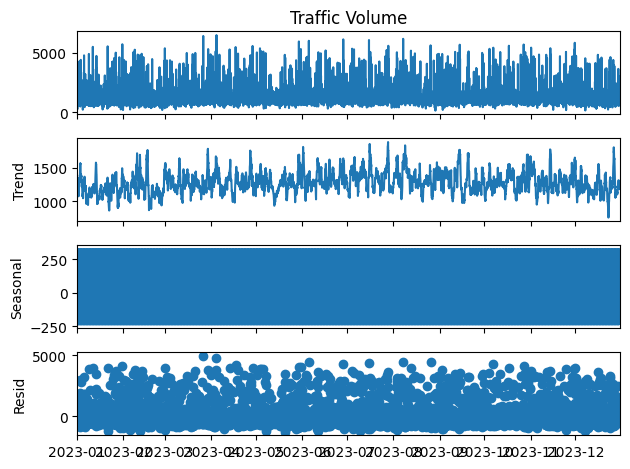

In [ ]:
decompose.plot()

In [ ]:
df.head()

,Weather,Events,Traffic Volume
Timestamp,,,
2023-01-01 00:00:00,1.0,False,803.0
2023-01-01 01:00:00,0.0,False,861.0
2023-01-01 02:00:00,0.0,False,582.0
2023-01-01 03:00:00,1.0,False,236.0
2023-01-01 04:00:00,1.0,False,569.0


In [ ]:
new_df = pd.DataFrame({
    'seasonal': decompose.seasonal,
    'trend': decompose.trend,
    'residual': decompose.resid,
    'Eventss': df['Events'],
    'traffic_volume': df['Traffic Volume']
})

In [ ]:
new_df.head()

,seasonal,trend,residual,Eventss,traffic_volume
Timestamp,,,,,
2023-01-01 00:00:00,-65.432976,NaN,NaN,False,803.0
2023-01-01 01:00:00,-237.567216,NaN,NaN,False,861.0
2023-01-01 02:00:00,-219.348150,NaN,NaN,False,582.0
2023-01-01 03:00:00,-162.645097,NaN,NaN,False,236.0
2023-01-01 04:00:00,-167.670923,NaN,NaN,False,569.0


In [ ]:
new_df.isna().sum()

,0
seasonal,0
trend,24
residual,24
Eventss,0
traffic_volume,0


In [ ]:
new_df.dropna(inplace=True)

In [ ]:
new_df.head()

,seasonal,trend,residual,Eventss,traffic_volume
Timestamp,,,,,
2023-01-01 12:00:00,326.145881,1238.229167,-641.375048,False,923.0
2023-01-01 13:00:00,218.856568,1238.645833,1495.497599,True,2953.0
2023-01-01 14:00:00,144.333611,1243.916667,-745.250277,False,643.0
2023-01-01 15:00:00,201.419412,1259.291667,-405.711079,False,1055.0
2023-01-01 16:00:00,236.727435,1280.000000,-204.727435,False,1312.0


In [ ]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(new_df[['seasonal','trend','residual']])
scaled_target = target_scaler.fit_transform(new_df[['traffic_volume']])
unscaled_features = new_df[['Eventss']].values
unscaled_features = unscaled_features.astype(float)
data = np.concatenate((scaled_features, unscaled_features, scaled_target), axis=1)


In [ ]:
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)
val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)

print(f'Train size: {len(train_data)}')
print(f'Test size: {len(test_data)}')
train_data.shape

Train size: 6098
Test size: 1307


(6098, 5)

In [ ]:
win_size = 30

train_ds = timeseries_dataset_from_array(
    train_data,
    targets=train_data[win_size:,4],
    sequence_length=win_size,
    batch_size=32
)

test_ds = timeseries_dataset_from_array(
    test_data,
    targets=test_data[win_size:,4],
    sequence_length=win_size,
    batch_size=32
)

val_ds = timeseries_dataset_from_array(
    val_data,
    targets=val_data[win_size:,4],
    sequence_length=win_size,
    batch_size=32
)

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

rnn_model = Sequential()
rnn_model.add(SimpleRNN(92,return_sequences=True))
rnn_model.add(SimpleRNN(32))


rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

rnn_history = rnn_model.fit(train_ds,validation_data=val_ds, epochs=20, batch_size=32)


Epoch 1/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0641 - val_loss: 0.0115
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 3/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0114 - val_loss: 0.0118
Epoch 4/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0111 - val_loss: 0.0100
Epoch 5/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0097 - val_loss: 0.0108
Epoch 6/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 7/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 8/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 9/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 10/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 11/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 12/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(92,return_sequences=True))
lstm_model.add(LSTM(32))

lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae'])

lstm_history = lstm_model.fit(train_ds,validation_data=val_ds, epochs=20, batch_size=32)


Epoch 1/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.0134 - mae: 0.0720 - val_loss: 0.0105 - val_mae: 0.0583
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0107 - mae: 0.0637 - val_loss: 0.0099 - val_mae: 0.0632
Epoch 3/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0101 - mae: 0.0626 - val_loss: 0.0097 - val_mae: 0.0563
Epoch 4/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0098 - mae: 0.0612 - val_loss: 0.0093 - val_mae: 0.0592
Epoch 5/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0095 - mae: 0.0604 - val_loss: 0.0091 - val_mae: 0.0600
Epoch 6/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0092 - mae: 0.0601 - val_loss: 0.0088 - val_mae: 0.0609
Epoch 7/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0089 - mae: 0.0600 - val_loss: 0.0077 - val_mae: 0.0577
Epoch 8/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0085 - mae: 0.0594 - val_loss: 0.0071 - val_mae: 0.0552
Epoch 9/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 49

In [ ]:
from keras.layers import GRU

gru_model = Sequential()
gru_model.add(GRU(92,return_sequences=True))
gru_model.add(GRU(32))

gru_model.add(Dense(1,activation='relu'))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

gru_history = gru_model.fit(train_ds,validation_data=val_ds, epochs=20, batch_size=32)


Epoch 1/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 0.0133 - val_loss: 0.0112
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 3/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0109 - val_loss: 0.0100
Epoch 4/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 5/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0099 - val_loss: 0.0091
Epoch 6/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 7/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 8/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 9/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0085 - val_loss: 0.0073
Epoch 10/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 11/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 12/20
190/190 ━━━━━━━━━━━━━

In [ ]:
rnn_predictions = rnn_model.predict(train_ds)
rnn_predictions_test = rnn_model.predict(test_ds)
rnn_predictions_val = rnn_model.predict(val_ds)


lstm_predictions = lstm_model.predict(train_ds)
lstm_predictions_test = lstm_model.predict(test_ds)
lstm_predictions_val = lstm_model.predict(val_ds)


gru_predictions = gru_model.predict(train_ds)
gru_predictions_test = gru_model.predict(test_ds)
gru_predictions_val = gru_model.predict(val_ds)

190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [ ]:
rnn_predictions.shape

(6068, 1)

In [ ]:
rnn_predictions = target_scaler.inverse_transform(rnn_predictions)
rnn_predictions_test = target_scaler.inverse_transform(rnn_predictions_test)
rnn_predictions_val = target_scaler.inverse_transform(rnn_predictions_val)


lstm_predictions = target_scaler.inverse_transform(lstm_predictions)
lstm_predictions_test = target_scaler.inverse_transform(lstm_predictions_test)
lstm_predictions_val = target_scaler.inverse_transform(lstm_predictions_val)


gru_predictions = target_scaler.inverse_transform(gru_predictions)
gru_predictions_test = target_scaler.inverse_transform(gru_predictions_test)
gru_predictions_val = target_scaler.inverse_transform(gru_predictions_val)

In [ ]:
rnn_predictions.shape

(6068, 1)

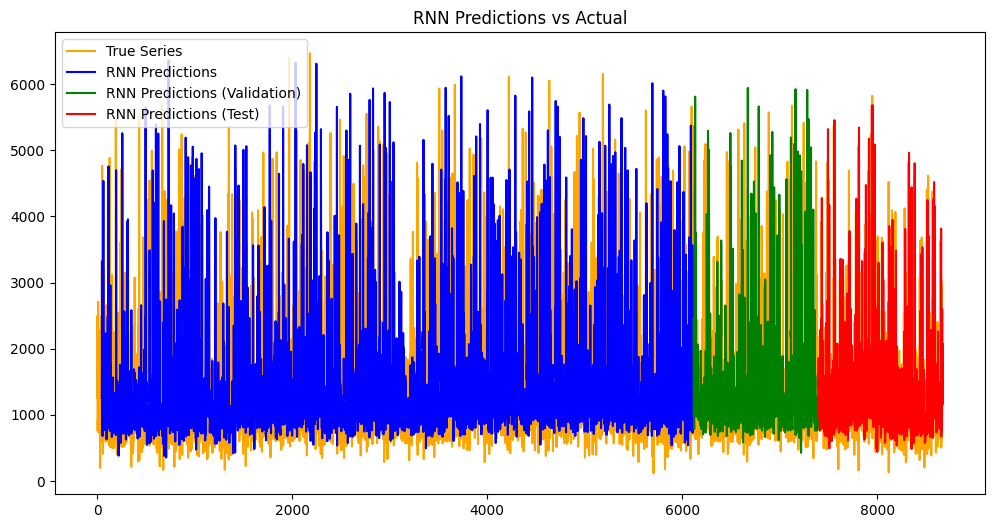

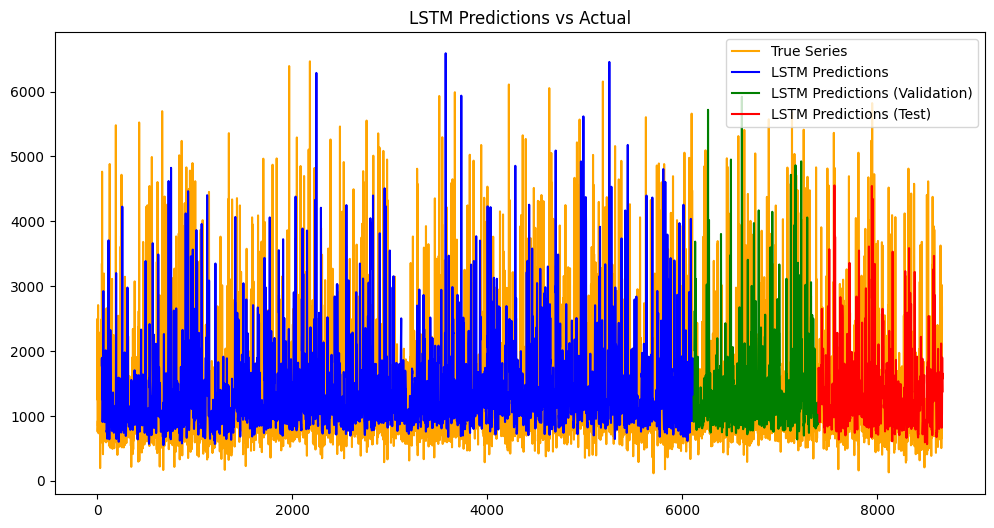

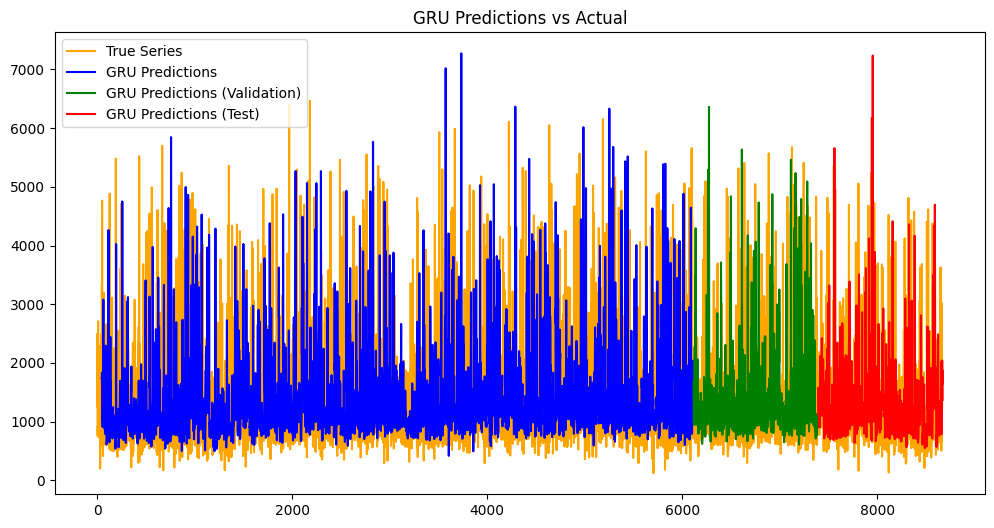

In [ ]:
import matplotlib.pyplot as plt
rnn_arr = np.zeros(len(new_df))
rnn_arr[:] = np.nan
lstm_arr = np.zeros(len(new_df))
lstm_arr[:] = np.nan
gru_arr = np.zeros(len(new_df))
gru_arr[:] = np.nan


#RNN

rnn_arr[win_size:len(rnn_predictions)+win_size] = rnn_predictions.flatten()
rnn_arr[len(rnn_predictions)+win_size:len(rnn_predictions)+len(rnn_predictions_val)+win_size] = rnn_predictions_val.flatten()
rnn_arr[len(rnn_predictions)+len(rnn_predictions_val)+win_size:len(rnn_predictions)+len(rnn_predictions_val)+len(rnn_predictions_test)+win_size] = rnn_predictions_test.flatten()

plt.figure(figsize=(12, 6))
plt.plot(new_df.iloc[win_size:,-1].values, label='True Series',color='orange')
plt.plot(rnn_arr[:len(rnn_predictions)+win_size], label='RNN Predictions', color='blue')
plt.plot(np.arange(len(rnn_predictions)+win_size, len(rnn_predictions)+len(rnn_predictions_val)+win_size),
         rnn_arr[len(rnn_predictions)+win_size:len(rnn_predictions)+len(rnn_predictions_val)+win_size],
         label='RNN Predictions (Validation)', color='green')
plt.plot(np.arange(len(rnn_predictions)+len(rnn_predictions_val)+win_size, len(rnn_arr)),
         rnn_arr[len(rnn_predictions)+len(rnn_predictions_val)+win_size:],
         label='RNN Predictions (Test)', color='red')

plt.legend()
plt.title('RNN Predictions vs Actual')
plt.show()

#LSTM
lstm_arr[win_size:len(lstm_predictions)+win_size] = lstm_predictions.flatten()
lstm_arr[len(lstm_predictions)+win_size:len(lstm_predictions)+len(lstm_predictions_val)+win_size] = lstm_predictions_val.flatten()
lstm_arr[len(lstm_predictions)+len(lstm_predictions_val)+win_size:len(lstm_predictions)+len(lstm_predictions_val)+len(lstm_predictions_test)+win_size] = lstm_predictions_test.flatten()

plt.figure(figsize=(12, 6))
plt.plot(new_df.iloc[win_size:,-1].values, label='True Series',color='orange')
plt.plot(lstm_arr[:len(lstm_predictions)+win_size], label='LSTM Predictions', color='blue')
plt.plot(np.arange(len(lstm_predictions)+win_size, len(lstm_predictions)+len(lstm_predictions_val)+win_size),
         lstm_arr[len(lstm_predictions)+win_size:len(lstm_predictions)+len(lstm_predictions_val)+win_size],
         label='LSTM Predictions (Validation)', color='green')
plt.plot(np.arange(len(lstm_predictions)+len(lstm_predictions_val)+win_size, len(lstm_arr)),
         lstm_arr[len(lstm_predictions)+len(lstm_predictions_val)+win_size:],
         label='LSTM Predictions (Test)', color='red')

plt.legend()
plt.title('LSTM Predictions vs Actual')
plt.show()


#GRU
gru_arr[win_size:len(gru_predictions)+win_size] = gru_predictions.flatten()
gru_arr[len(gru_predictions)+win_size:len(gru_predictions)+len(gru_predictions_val)+win_size] = gru_predictions_val.flatten()
gru_arr[len(gru_predictions)+len(gru_predictions_val)+win_size:len(gru_predictions)+len(gru_predictions_val)+len(gru_predictions_test)+win_size] = gru_predictions_test.flatten()

plt.figure(figsize=(12, 6))
plt.plot(new_df.iloc[win_size:,-1].values, label='True Series',color='orange')
plt.plot(gru_arr[:len(gru_predictions)+win_size], label='GRU Predictions', color='blue')
plt.plot(np.arange(len(gru_predictions)+win_size, len(gru_predictions)+len(gru_predictions_val)+win_size),
         gru_arr[len(gru_predictions)+win_size:len(gru_predictions)+len(gru_predictions_val)+win_size],
         label='GRU Predictions (Validation)', color='green')
plt.plot(np.arange(len(gru_predictions)+len(gru_predictions_val)+win_size, len(gru_arr)),
         gru_arr[len(gru_predictions)+len(gru_predictions_val)+win_size:],
         label='GRU Predictions (Test)', color='red')

plt.legend()
plt.title('GRU Predictions vs Actual')
plt.show()

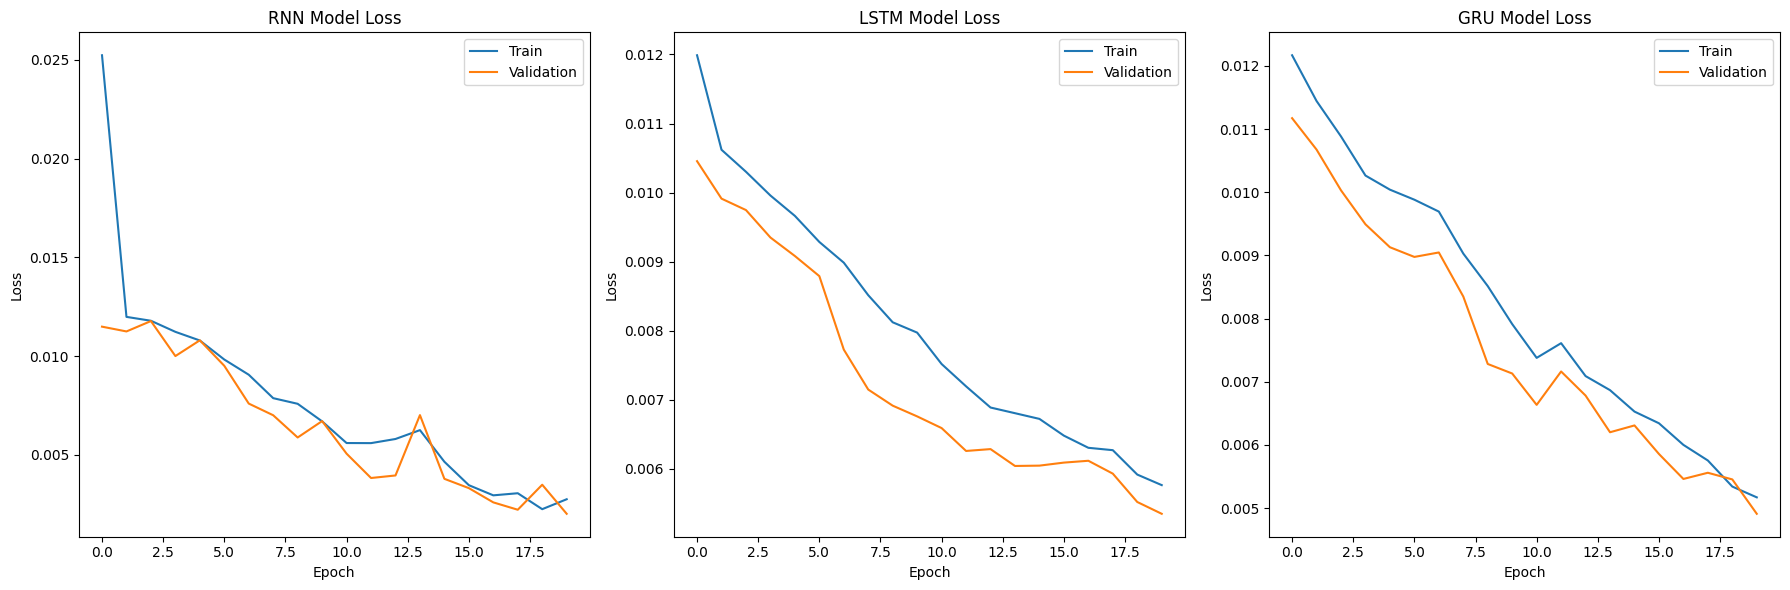

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

#RNN model
axs[0].plot(rnn_history.history['loss'])
axs[0].plot(rnn_history.history['val_loss'])
axs[0].set_title('RNN Model Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper right')

#LSTM model
axs[1].plot(lstm_history.history['loss'])
axs[1].plot(lstm_history.history['val_loss'])
axs[1].set_title('LSTM Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')

#GRU model
axs[2].plot(gru_history.history['loss'])
axs[2].plot(gru_history.history['val_loss'])
axs[2].set_title('GRU Model Loss')
axs[2].set_ylabel('Loss')
axs[2].set_xlabel('Epoch')
axs[2].legend(['Train', 'Validation'], loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()


In [ ]:
def sliding_window_prediction(model, test_data, target_scaler):
    win_size=30
    predictions = []
    input_sequence = test_data[:win_size]

    for i in range(len(test_data) - win_size):
        input_sequence_reshaped = input_sequence[np.newaxis, ...]
        pred = model.predict(input_sequence_reshaped,verbose=0)
        pred_rescaled = target_scaler.inverse_transform(pred)
        predictions.append(pred_rescaled.flatten()[0])

        next_input = test_data[win_size + i]
        input_sequence = np.concatenate((input_sequence[1:], [next_input]), axis=0)

    return predictions

win_size = 48

def sliding_window_prediction_with_decompose(model, test_data, target_scaler):
    win_size=48
    predictions = []
    input_sequence = test_data[:win_size].copy()

    for i in range(len(test_data) - win_size):
        input_sequence_reshaped = input_sequence[np.newaxis, ...]
        pred = model.predict(input_sequence_reshaped, verbose=0)
        pred_rescaled = target_scaler.inverse_transform(pred)
        predictions.append(pred_rescaled.flatten()[0])

        input_for_decompose = np.append(input_sequence[:, -1], pred_rescaled)
        decomposed = seasonal_decompose(input_for_decompose, model='additive', period=24)
         # Convert NumPy arrays to Pandas Series for dropna()
        decomposed_trend = pd.Series(decomposed.trend)
        decomposed_seasonal = pd.Series(decomposed.seasonal)
        decomposed_resid = pd.Series(decomposed.resid)

        decomposed_trend.dropna(inplace=True)
        decomposed_seasonal.dropna(inplace=True)
        decomposed_resid.dropna(inplace=True)
        next_input = test_data[win_size + i].copy()
        next_input[0] = decomposed_trend.iloc[-1]
        next_input[1] = decomposed_seasonal.iloc[-1]
        next_input[2] = decomposed_resid.iloc[-1]
        next_input[4] = pred_rescaled.flatten()[0]

        input_sequence = np.concatenate((input_sequence[1:], [next_input]), axis=0)

    return predictions


In [ ]:
# sliding_predictions_rnn = sliding_window_prediction(rnn_model, test_data, target_scaler)
# sliding_predictions_lstm = sliding_window_prediction(lstm_model, test_data, target_scaler)
# sliding_predictions_gru = sliding_window_prediction(gru_model, test_data, target_scaler)

sliding_predictions_de_rnn = sliding_window_prediction_with_decompose(rnn_model, test_data, target_scaler)
sliding_predictions_de_lstm = sliding_window_prediction_with_decompose(lstm_model, test_data, target_scaler)
sliding_predictions_de_gru = sliding_window_prediction_with_decompose(gru_model, test_data, target_scaler)

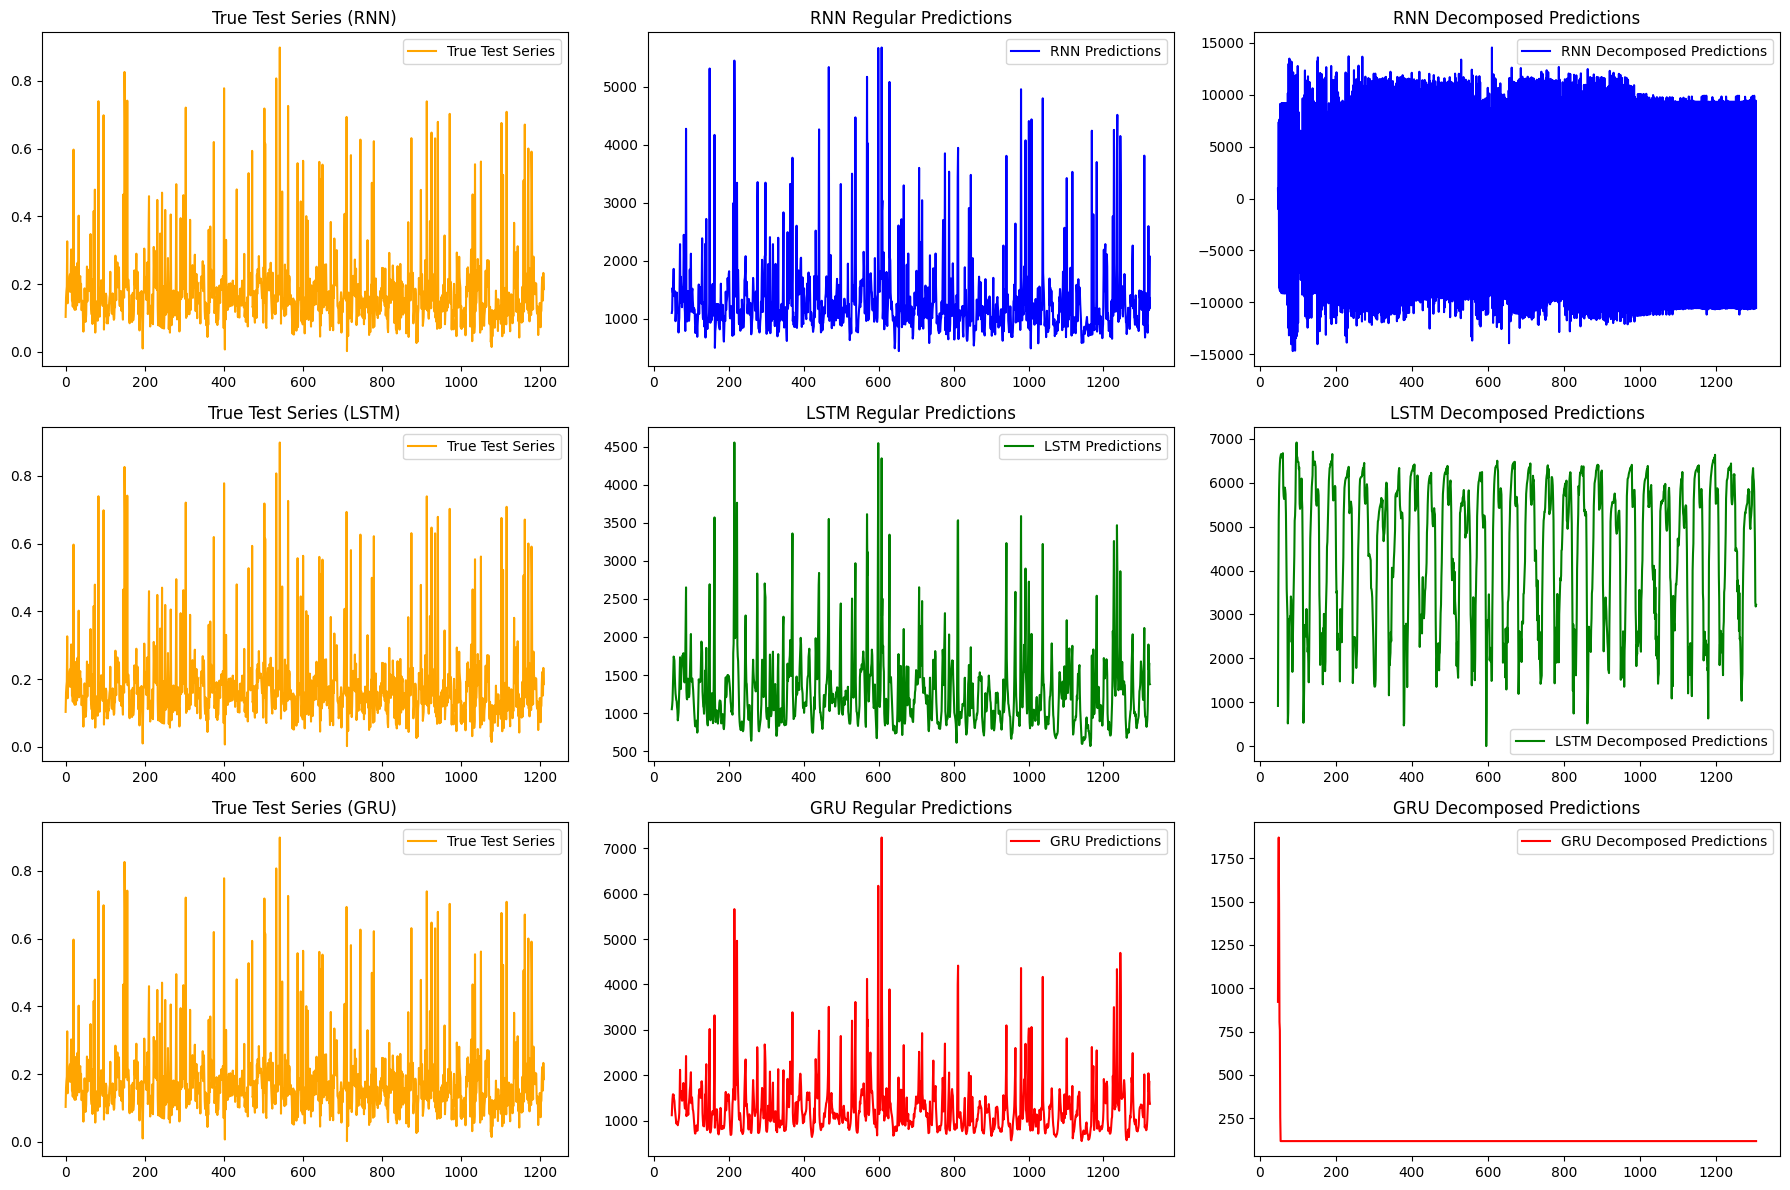

In [ ]:
import matplotlib.pyplot as plt

true_test_series = test_data[win_size:-win_size, 4]

fig, axs = plt.subplots(3, 3, figsize=(18, 12))

# Plot for RNN
axs[0, 0].plot(true_test_series, label='True Test Series', color='orange')
axs[0, 0].set_title('True Test Series (RNN)')
axs[0, 0].legend()

axs[0, 1].plot(np.arange(win_size, len(sliding_predictions_rnn) + win_size), sliding_predictions_rnn, label='RNN Predictions', color='blue')
axs[0, 1].set_title('RNN Regular Predictions')
axs[0, 1].legend()

axs[0, 2].plot(np.arange(win_size, len(sliding_predictions_de_rnn) + win_size), sliding_predictions_de_rnn, label='RNN Decomposed Predictions', color='blue')
axs[0, 2].set_title('RNN Decomposed Predictions')
axs[0, 2].legend()

# Plot for LSTM
axs[1, 0].plot(true_test_series, label='True Test Series', color='orange')
axs[1, 0].set_title('True Test Series (LSTM)')
axs[1, 0].legend()

axs[1, 1].plot(np.arange(win_size, len(sliding_predictions_lstm) + win_size), sliding_predictions_lstm, label='LSTM Predictions', color='green')
axs[1, 1].set_title('LSTM Regular Predictions')
axs[1, 1].legend()

axs[1, 2].plot(np.arange(win_size, len(sliding_predictions_de_lstm) + win_size), sliding_predictions_de_lstm, label='LSTM Decomposed Predictions', color='green')
axs[1, 2].set_title('LSTM Decomposed Predictions')
axs[1, 2].legend()

# Plot for GRU
axs[2, 0].plot(true_test_series, label='True Test Series', color='orange')
axs[2, 0].set_title('True Test Series (GRU)')
axs[2, 0].legend()

axs[2, 1].plot(np.arange(win_size, len(sliding_predictions_gru) + win_size), sliding_predictions_gru, label='GRU Predictions', color='red')
axs[2, 1].set_title('GRU Regular Predictions')
axs[2, 1].legend()

axs[2, 2].plot(np.arange(win_size, len(sliding_predictions_de_gru) + win_size), sliding_predictions_de_gru, label='GRU Decomposed Predictions', color='red')
axs[2, 2].set_title('GRU Decomposed Predictions')
axs[2, 2].legend()

# Adjust layout for readability
plt.tight_layout()
plt.show()


In [ ]:
len(train_data[4])

6098

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

# Find the best ARIMA order automatically
auto_arima_model = auto_arima(target_scaler.inverse_transform(train_data[:,4].reshape(-1,1)), seasonal=True, suppress_warnings=True)

# Fit the model with the best order
best_arima_order = auto_arima_model.order
arima_model = ARIMA(target_scaler.inverse_transform(train_data[:,4].reshape(-1,1)), order=best_arima_order)
arima_fit = arima_model.fit()



In [ ]:
# Forecast on the test data
arima_forecast = arima_fit.forecast(steps=len(test_data))

In [ ]:
# Plot ARIMA results
plt.figure(figsize=(10, 5))
plt.plot(new_df['traffic_volume'][len(train_data):len(train_data)+len(test_data)].values, label='True Test Series', color='orange')
plt.plot(arima_forecast, label='ARIMA Predictions', color='blue')
plt.title('ARIMA Predictions vs True Series (Auto ARIMA)')
plt.legend()
plt.show()

In [ ]:
# Prepare exogenous variables (events)
exog_train = train_data[:, 3].reshape(-1, 1)
exog_test = test_data[:, 3].reshape(-1, 1)

# Find the best SARIMA order automatically with exogenous variables
auto_sarima_model = auto_arima( train_data[:, 4], exogenous=exog_train, seasonal=True, suppress_warnings=True)

# Fit the model with the best order
best_sarima_order = auto_sarima_model.order
sarima_model = ARIMA( train_data[:, 4], exog=exog_train, order=best_sarima_order, m=24, stepwise=True)
sarima_fit = sarima_model.fit()


In [ ]:
# Forecast on the test data, including exogenous variables
sarima_forecast = sarima_fit.forecast(steps=len(test_data), exog=exog_test)

In [ ]:
sarima_forecast.shape

In [ ]:
# Plot SARIMA results
plt.figure(figsize=(10, 5))
plt.plot(new_df['traffic_volume'][len(train_data):len(train_data) + len(test_data)].values, label='True Test Series', color='orange')
plt.plot(target_scaler.inverse_transform(sarima_forecast.reshape(-1,1)), label='SARIMA Predictions', color='blue')
plt.title('SARIMA Predictions vs True Series (Auto SARIMA with Events)')
plt.legend()
plt.show()